Latent Factor DCMM Analysis: Dynamic Count Mixture Model

A Dynamic Count Mixture Model (DCMM) is the combination of Bernoulli and Poisson DGLMs. The Bernoulli DGLM models the probability of a zero outcome, while the Poisson models the outcome, conditional on it being non-zero (Berry and West, 2019)

A DCMM is useful to capture a higher prevalence of  outcomes than in a standard Poisson DGLM.

Latent Factors

The second concept is the use of latent factors for multiscale modeling. This example features simulated data from a retail sales setting. There is data for an item, and also for total sales at the store. The total sales are smoother and more predictable than the item level sales. A model is fit to the total sales which includes a day-of-week seasonal effect. This seasonal effect is extracted from the model on total sales, and used as a predictor in the item level model.

Modeling effects at different levels of a hierarchy - aka multiscale modeling - can improve forecast accuracy, because the sales of an individual can be very noisy, making it difficult to learn accurate patterns.

Copula Forecasting

The final concept is Copula forecasting. In this example we are focusing on forecasting sales 1 through 14 days into the future. To do this, we will simulate from the joint forecast distribution 1:14 days into the future. This is accomplished in an efficient manner through the use of a Copula model, which accounts for dependence in the forecasts across days.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pybats.analysis import analysis, analysis_dcmm
from pybats.latent_factor import Y_lf, seas_weekly_lf, hol_lf, multi_latent_factor
from pybats.shared import load_dcmm_latent_factor_example
from pandas.tseries.holiday import USFederalHolidayCalendar
from pybats.plot import plot_data_forecast, ax_style
from pybats.point_forecast import median
from pybats.loss_functions import MAD

We start by loading the simulated retail sales data: The dataframe 'totaldata' has the total daily sales in a store, along with a predictor, which represents a measure of average price. The dataframe 'data' has the sales of a single item, and along with a predictor which represents the daily change in price.

In [3]:
data = load_dcmm_latent_factor_example()
print(data.keys())
totaldata, data = data.values()
totaldata['Y'] = np.log(totaldata['Y'] + 1)
print(len(totaldata['Y']))
totaldata.head()

dict_keys(['totaldata', 'data'])
1462


,Y,X
2014-06-01,5.613128,-0.133124
2014-06-02,5.602119,-0.070102
2014-06-03,5.831882,1.020901
2014-06-04,5.393628,2.219605
2014-06-05,5.267858,-0.970556


In [4]:
print(len(data['Y']))
data.head()

1462


,Y,X
2014-06-01,14.0,2.413448
2014-06-02,13.0,0.989871
2014-06-03,7.0,-0.489734
2014-06-04,34.0,-1.544868
2014-06-05,15.0,1.639670


In [5]:
#Define hyper parameters
rho = .2
k = 14 # Number of days ahead that we will forecast
nsamps = 100
prior_length = 21
holidays=USFederalHolidayCalendar.rules

Next, we define the window of time that we want to forecast over. For each day within this time period, the model will sample from the path (joint) forecast distribution 1:k days into the future.

In [6]:
# Define forecast range for final year of data
T = len(totaldata)
forecast_end_date = totaldata.index[-k]
forecast_start_date = forecast_end_date - pd.DateOffset(days=365)

The first analysis is run on the 'totaldata', which is used to learn a latent factor. In this case, we fit a normal DLM to the log of total sales in order to learn the weekly season effect, which is stored in the latent factor.

In [7]:
# Get multiscale signal (a latent factor) from higher level log-normal model
latent_factors = analysis(totaldata['Y'].values, totaldata['X'].values, k,
                          forecast_start_date, forecast_end_date, dates=totaldata.index,
                          seasPeriods=[7], seasHarmComponents=[[1,2,3]],
                          holidays=holidays, family="normal", ret=['new_latent_factors'],
                          new_latent_factors= [Y_lf, seas_weekly_lf, hol_lf],
                          prior_length=prior_length)

beginning forecasting


In [8]:
#We now have a list of the 3 latent factors, which have been populated by the model.
#We can see their respective dimensions below:
[lf.p for lf in latent_factors]

[1, 7, 11]

The first latent factor is Y_lf, which stores both the actual total sales and the forecast total sales. The second is seas_weekly_lf, which is a 7−dimensional vector. Each day, the element for today is populated with the estimated seasonal effect, while the other 6 values are set to 0. Finally, we defined 10 holidays. This latent factor is only populated on the holidays themselves, so it is mostly just 0.

In [9]:
#We can get the update mean for each latent factor at any given date:
latent_factor_names = ['Total Sales', 'Weekly Seasonal', 'Holiday']
for lf, name in zip(latent_factors, latent_factor_names):
    print(name + ' mean:', lf.get_lf(forecast_start_date)[0].round(2))

Total Sales mean: 5.56
Weekly Seasonal mean: [ 0.    0.    0.    0.   -0.06  0.    0.  ]
Holiday mean: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
#And also the forecast mean for any date in the forecast window. Here are the 1:14 day ahead forecasts for the total sales:
print(latent_factor_names[0] + ' forecast mean: ', np.array(latent_factors[0].get_lf_forecast(forecast_start_date)[0]).round(2))

Total Sales forecast mean:  [5.42 5.65 5.76 5.56 5.39 5.36 5.35 5.43 5.63 5.8  5.13 5.38 5.36 5.35]


In [11]:
#The 14−day ahead forecast of the seasonal effects makes it clear how the latent factor works:
print(latent_factor_names[1] + ' forecast mean: ')
print(np.array(latent_factors[1].get_lf_forecast(forecast_start_date)[0]).round(2))

Weekly Seasonal forecast mean: 
[[ 0.    0.    0.    0.   -0.06  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.15  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.29]
 [ 0.03  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.12  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.13  0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.15  0.    0.    0.  ]
 [ 0.    0.    0.    0.   -0.06  0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.15  0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.29]
 [ 0.03  0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.12  0.    0.    0.    0.    0.  ]
 [ 0.    0.   -0.13  0.    0.    0.    0.  ]
 [ 0.    0.    0.   -0.15  0.    0.    0.  ]]


In [12]:
#The same output can be created for the holiday latent factor, but it will be all 0's except
#when there is a holiday in the next 14 days. Now let's combine these latent factors into a 
#single multi_latent_factor, and put them to use in an analysis of the individual item sales. 
#First we create the multi latent factor:
multi_lf = multi_latent_factor(latent_factors[:3])
print('Total dimension :', multi_lf.p)

Total dimension : 19


First analysis we run a standard analysis, while passing in the multi_lf as our latent factor. We're setting the discount factor on the latent factor component as dellf=1, which means no discounting. This is because the weekly seasonal pattern and holidays are "0" so often. Another option would be to define dellf as an 18−dimensional vector, with a separate discount factor for each element of the latent factor.

In [26]:
nsamps = 1000
""" mod, forecast_samples = analysis(data['Y'].values, data['X'].values, k,
                                 forecast_start_date, forecast_end_date,
                                 nsamps=nsamps,
                                 latent_factor = multi_lf,
                                 dates=data.index,
                                 prior_length = prior_length,
                                 s0=5, dellf=1)
forecast = median(forecast_samples) """

beginning forecasting


The second analysis fits a DCMM to 'data', which is the simulated sales of a single item. The "weekly seasonal" latent factor we derived above is used as a predictive signal for the sales of this individual item. On each day within the forecasting period, a copula is used to draw joint forecast samples 1:k days ahead.

In [13]:
# Update and forecast the model
mod, forecast_samples = analysis_dcmm(data['Y'].values, data['X'].values.reshape(-1,1), k,
                                      forecast_start_date, forecast_end_date,
                                      prior_length=prior_length, nsamps=nsamps, rho=rho,
                                      latent_factor=latent_factors[1], dates=totaldata.index)
forecast = median(forecast_samples)

beginning forecasting


Finally we can examine the results, first by plotting both the 1- and 14- step ahead forecasts. The point forecast is the median (blue line), and the forecast samples provide easy access to 95% credible intervals.

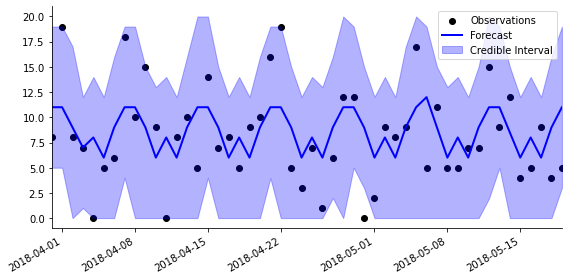

In [29]:
# Plotting 1-step ahead forecasts
horizon = 1 
plot_length = 50
fig, ax = plt.subplots(figsize=(8,4))
start_date = forecast_end_date + pd.DateOffset(horizon - plot_length)
end_date = forecast_end_date + pd.DateOffset(horizon - 1)
ax = plot_data_forecast(fig, ax, data.loc[start_date:end_date].Y,
                        forecast[-plot_length:,horizon - 1],
                        forecast_samples[:,-plot_length:,horizon - 1],
                        data.loc[start_date:end_date].index,
                        linewidth = 2)
ax = ax_style(ax, legend=['Observations', 'Forecast', 'Credible Interval'])

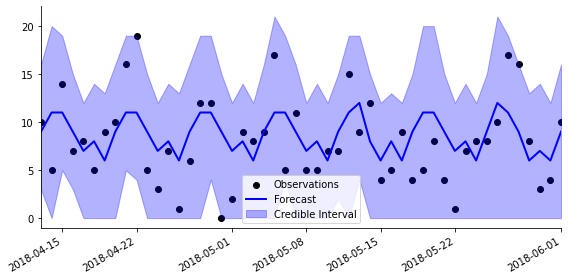

In [30]:
# Plotting 14-step ahead forecasts
horizon = 14
plot_length = 50
fig, ax = plt.subplots(figsize=(8,4))
start_date = forecast_end_date + pd.DateOffset(horizon - plot_length)
end_date = forecast_end_date + pd.DateOffset(horizon - 1)
ax = plot_data_forecast(fig, ax, data.loc[start_date:end_date].Y,
                        forecast[-plot_length:,horizon - 1],
                        forecast_samples[:,-plot_length:,horizon - 1],
                        data.loc[start_date:end_date].index,
                        linewidth = 2)
ax = ax_style(ax, legend=['Observations', 'Forecast', 'Credible Interval'])

To evaluate the point forecasts, we can look at the mean absolute deviation (MAD) between the forecast median and the observations across forecast horizons. Interestingly, there is only a small increase in the MAD for longer forecast horizons.

In [31]:
# Mean absolute deviation at increasing forecast horizons
horizons = list(range(1, k+1))
list(map(lambda k: MAD(data.loc[forecast_start_date + pd.DateOffset(k-1):forecast_end_date + pd.DateOffset(k-1)].Y,
                      forecast[:,k-1]),
         horizons))

[2.871584699453552,
 2.8456284153005464,
 2.887978142076503,
 2.877049180327869,
 2.8551912568306013,
 2.859289617486339,
 2.866120218579235,
 2.8743169398907105,
 2.859289617486339,
 2.877049180327869,
 2.878415300546448,
 2.862021857923497,
 2.900273224043716,
 2.8948087431693987]